About the Dataset

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research(a set of SMS messages in English of 5,574 messages: ham/spam))
The files contain one message per line where each line is composed by two columns: category contains the label and messsage contains the raw text
It is used to build a machine learning model that can detect spam messages

Importing the necessary libraries

In [202]:
import numpy as np
import pandas as pd
import xgboost as xg
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
#contains a number of useful constants and classes for working with strings
import string
import pickle

#create word cloud visualizations, where the size of each word in the visualization represents its frequency in a given text
from wordcloud import WordCloud
#count the occurrences of elements in a collection
from collections import Counter
from sklearn.model_selection import train_test_split
#TfidfVectorizer and CountVectorizer used in converting text data into numerical features
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#the needed evaluation metrics
from sklearn.metrics import accuracy_score, precision_score
#label encoding to transform categorical data into a numerical one
from sklearn.preprocessing import LabelEncoder
#importing the alogirthms to be used for model training
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [168]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
#This class is used to lemmatize words, which means reducing them to their base form
from nltk.stem import WordNetLemmatizer
#WordNet is a large lexical database of English, where words are grouped into sets of synonyms called synsets
nltk.download("wordnet")
#multilingual lexical database. It extends the original English WordNet to other languages
nltk.download("omw-1.4")
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\AYA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Installing the needed libraries

In [147]:
!pip install wordcloud

     -------------------------------------- 152.1/152.1 kB 1.5 MB/s eta 0:00:00


In [145]:
!pip install spacy

     ---------------------------------------- 12.3/12.3 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 3.7 MB/s eta 0:00:00
     -------------------------------------- 481.6/481.6 kB 3.3 MB/s eta 0:00:00
     -------------------------------------- 181.6/181.6 kB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 48.9/48.9 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 94.7/94.7 kB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 45.9/45.9 kB ? eta 0:00:00
     ---------------------------------------- 7.4/7.4 MB 3.8 MB/s eta 0:00:00


Uploading the dataset

In [169]:
df = pd.read_csv('mail_data.csv')

In [170]:
#checking the first five columns of the dataset
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [171]:
#checking the number of rows and columns in the dataframe
df.shape

(5572, 2)

Data Preprocessing

Checking the missing values (to fill them if needed)

In [172]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

Checking the duplicated values

In [173]:
df.duplicated().sum()

415

Dropping the found, duplicated values 

In [174]:
df.drop_duplicates(inplace=True)

Rechecking if the duplicated values removed

In [175]:
df.duplicated().sum()

0

In [176]:
#Renaming the columns to be more understandable
df.rename(columns={'Category':'Target','Message':'SMS'},inplace=True)

In [177]:
#Recheking the change of the columns' names
df.head()

,Target,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [178]:
#Label encoder, where 0 is the ham and 1 is the spam
encoder=LabelEncoder()
df['Target']=encoder.fit_transform(df['Target'])

In [179]:
#Rechecking the label encoding step
df.head()

,Target,SMS
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


EDA Step

Checking if the data is balanced or not

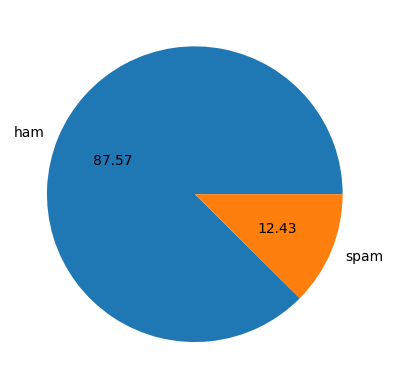

In [180]:
plt.pie(df['Target'].value_counts(),labels=['ham','spam'],autopct='%0.2f')
plt.show()

The data is imbalanced as the ham to spam has a ratio of about 7:1

In [182]:
# number of characters in SMSs
df['Chars']=df['SMS'].apply(len)
# number of words in SMSs
#word_tokenize tokenizes text into words
df['Words']=df['SMS'].apply(lambda x:len(nltk.word_tokenize(x)))
# number of sentences in SMSs
df['Sentences']=df['SMS'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [183]:
df.head()

,Target,SMS,Chars,Words,Sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [184]:
df[["Chars","Words","Sentences"]].describe()

,Chars,Words,Sentences
count,5157.000000,5157.000000,5157.000000
mean,79.103936,18.557882,1.950553
std,58.382922,13.406024,1.362981
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,118.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [185]:
#for the ham messages
df[df['Target']==0][["Chars","Words","Sentences"]].describe()

,Chars,Words,Sentences
count,4516.000000,4516.000000,4516.000000
mean,70.869353,17.264836,1.806244
std,56.708301,13.587852,1.281910
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [186]:
#for the spam messages
df[df['Target']==1][["Chars","Words","Sentences"]].describe()

,Chars,Words,Sentences
count,641.000000,641.000000,641.000000
mean,137.118565,27.667707,2.967239
std,30.399707,7.103501,1.480241
min,7.000000,2.000000,1.000000
25%,130.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,8.000000


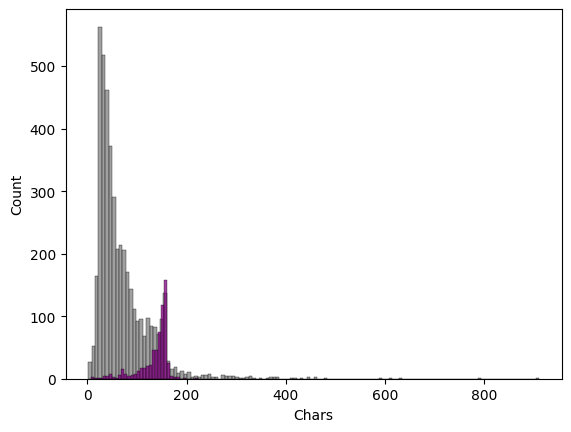

In [187]:
sns.histplot(df[df['Target']==0]['Chars'],color='gray')
sns.histplot(df[df['Target']==1]['Chars'],color='purple')
plt.show()

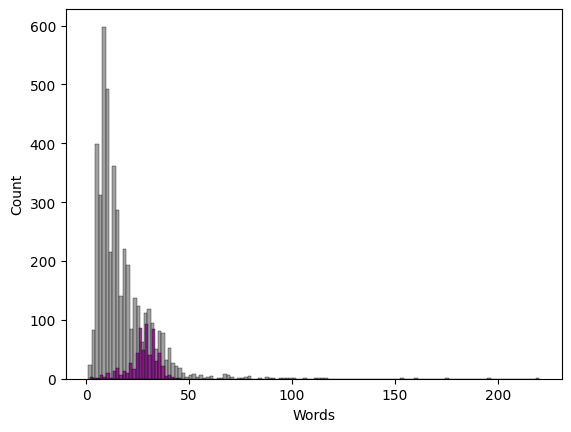

In [188]:
sns.histplot(df[df['Target']==0]['Words'],color='gray')
sns.histplot(df[df['Target']==1]['Words'],color='purple')
plt.show()

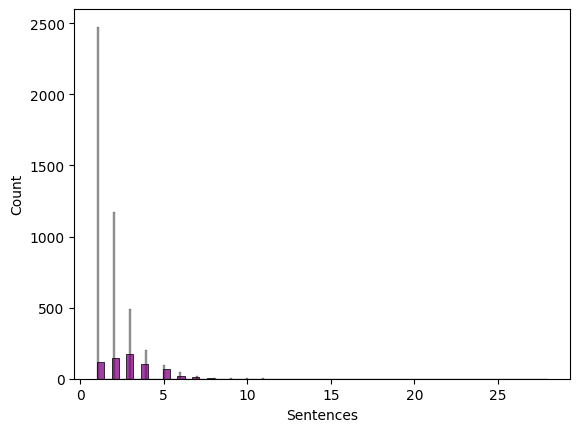

In [189]:
sns.histplot(df[df['Target']==0]['Sentences'],color='gray')
sns.histplot(df[df['Target']==1]['Sentences'],color='purple')
plt.show()

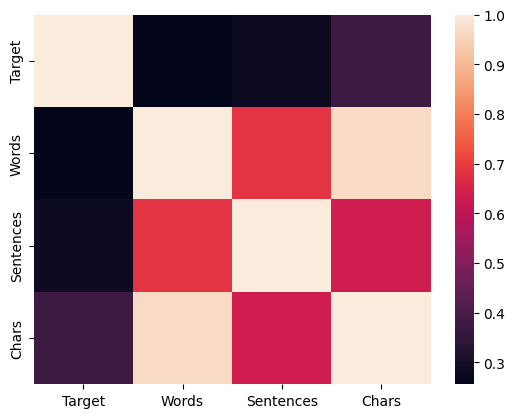

In [190]:
#heatmap is used to check the correlation between the columns of the dataset
sns.heatmap(df[['Target','Words','Sentences','Chars']].corr())
plt.show()

In [143]:
#the latest version of the nltk
!pip install nltk==3.8.1

     ---------------------------------------- 1.5/1.5 MB 54.4 kB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [155]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 1.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [191]:
#imports the spaCy library and loads the English language model called "en_core_web_sm"
nlp = spacy.load("en_core_web_sm")
#function to lematize the words
def limit(word):
    obj=nlp(word)
    for token in obj:
        #returns the base form of the token
        return token.lemma_

In [192]:
#function for the text preprocessing
def process(text):
    import string
    text=text.lower()
    text=nltk.word_tokenize(text)
    #limit the word if it is only within the stopwords
    text=[limit(word) for word in text if word not in nltk.corpus.stopwords.words('english')]
    #tokenize it if the word is not a punctation mark
    text=[word for word in text if word not in string.punctuation]
    #tokenize it if the word is a number(alphanumeric)
    text=[word for word in text if word.isalnum()]
    text=' '.join(text)
    return text

In [193]:
#a new column for the converted, preprocessed messages (to be more easier in modelling)
df['Converted_SMS']=df['SMS'].apply(process)

In [194]:
df

,Target,SMS,Chars,Words,Sentences,Converted_SMS
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah not think go usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,160,35,4,2nd time try 2 contact u pound prize 2 claim e...
5568,0,Will ü b going to esplanade fr home?,36,9,1,ü b go esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,pity mood suggestion
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like would interested buy someth...


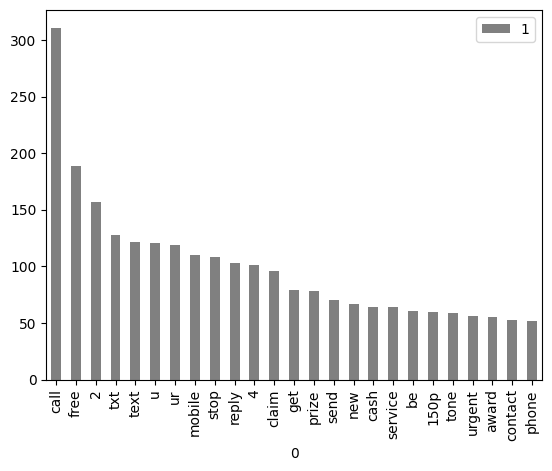

In [198]:
spams=[]
for i in df[df['Target']==1]['Converted_SMS'].to_list():
    #splits the message into individual words
    for word in i.split():
        spams.append(word)
#DataFrame is created from the most common 25 words using the Counter class from the collections module
pd.DataFrame(Counter(spams).most_common(25)).plot(kind='bar',x=0,y=1,color='gray')
plt.show()

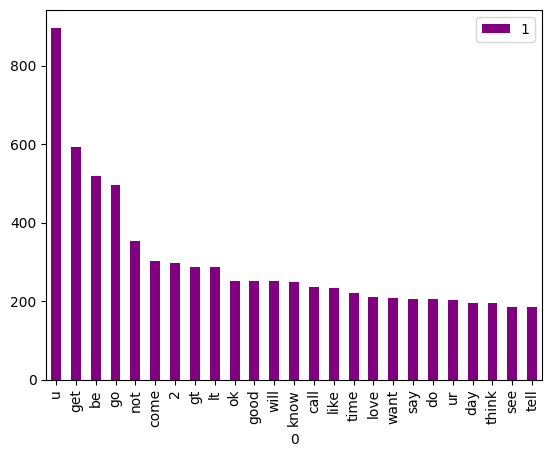

In [199]:
hams=[]
for i in df[df['Target']==0]['Converted_SMS'].to_list():
    for word in i.split():
        hams.append(word)
#DataFrame is created from the most common 25 words using the Counter class from the collections module
pd.DataFrame(Counter(hams).most_common(25)).plot(kind='bar',x=0,y=1,color='purple')
plt.show()

In [200]:
#remove the index and apply this modification in a new csv file
df.to_csv('mail_data1.csv',index=False)

In [203]:
#used to convert the text data into a matrix of token counts
cv=CountVectorizer()
#Iconverts the text data into a matrix representation(each row represents a document (message) and each column represents a unique word in the corpus)
X=cv.fit_transform(df['Converted_SMS']).toarray()
y=df['Target'].values

In [204]:
#divide the data into training and testing set with the usual ratio of 4:1 respectively
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [205]:
#Initializing Classifiers
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
rfc = RandomForestClassifier()
xgb = XGBClassifier()

#Creating Lists for Models and Model Names
models = [mnb, gnb, bnb, rfc, xgb]
model_names = ['MultinomialNB', 'GaussianNB', 'BernoulliNB', 'RandomForestClassifier', 'XGBoost']

In [216]:
#Training and Evaluating Models
accuracy = []
for model, model_name in zip(models, model_names):
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    print('Model name:  {}   Accuracy:  {}'.format(model_name, round(accuracy_score(y_test, y_pred), 2)))
    print('Model name:  {}   Precision:  {}'.format(model_name, round(precision_score(y_test, y_pred), 2)))

Model name:  MultinomialNB   Accuracy:  0.97
Model name:  MultinomialNB   Precision:  0.85
Model name:  GaussianNB   Accuracy:  0.88
Model name:  GaussianNB   Precision:  0.51
Model name:  BernoulliNB   Accuracy:  0.97
Model name:  BernoulliNB   Precision:  0.95
Model name:  RandomForestClassifier   Accuracy:  0.97
Model name:  RandomForestClassifier   Precision:  0.99
Model name:  XGBoost   Accuracy:  0.98
Model name:  XGBoost   Precision:  0.93


In [ ]:
#RandomForestClassifier is the best model out of these ones

In [221]:
#Save trained model to file
with open('random_forest_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [224]:
#Load the pre-trained model from the file
with open('random_forest_classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)
    
Input_SMS = ["Congratulations! You have been selected to receive a free vacation to the Bahamas. Click the link to claim your prize."]
# Convert text to feature vectors
InputFeatures = cv.transform(Input_SMS)

# Making prediction
Prediction = classifier.predict(InputFeatures)
print(Prediction)

if Prediction[0] == 1:
    print('Spam message')
else:
    print('Ham message')

[1]
Spam mail


In [ ]:
#It predicts correcly since the input sms was a spam mail, which the model was able to detect it correcly